In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNWithZScore, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote.csv')
data.head()

,userId,wine,rate
0,5ccd8030-047b-432c-a630-d784ab415756,Valpolicella Ripasso,3
1,df904a46-c461-4233-9d44-6ac11a8bbddc,Astrale,3
2,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Bricco Riva Bianca,3
3,bc79b0e3-064d-4240-86de-e86499f577e8,3/11 Syrah and blend #4,3
4,5ccd8030-047b-432c-a630-d784ab415756,Valpolicella Ripasso Classico Superiore Pojega,4


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class KnnWithZSore (KNNWithZScore):
    def __init__(self, sim_options={}, bsl_options = {}):
        KNNWithZScore.__init__(self, sim_options=sim_options, bsl_options= bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
        
    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNWithZScore.fit(self, trainset_fold)
            train_prediction = KNNWithZScore.test(self, trainset_fold.build_testset())
            prediction = KNNWithZScore.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNWithZScore.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        '''Return the k nearest neighbors of user_id'''
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        '''Return the k nearest neighbors of item_id'''
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## KnnWithZScore SGD

* knn_with_zscore cosine, user based

In [4]:
knn_with_zscore = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore.create_reader(data)
predictions = knn_with_zscore.fit()
#acc
metrics = knn_with_zscore.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5496
RMSE: 1.4224
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5649
RMSE: 1.3979
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5493
RMSE: 1.3485
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5655
RMSE: 1.4767
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5294
RMSE: 1.5100
###############################################
The Results are: 

Average RMSE on Training Set: 0.5517467604954079
Average RMSE on Test Set: 1.4311063448201022
RMSE: 1.3870
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.3869608991484417
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.3870
MAE:  1.0573
MSE: 1.9237
Precision: 0.03
Recall: 0.02
the acc is 30.37


/tmp/ipykernel_18518/1944145904.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore cosine, item based

In [5]:
knn_with_zscore2 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore2.create_reader(data)
predictions = knn_with_zscore2.fit()
#acc
metrics = knn_with_zscore2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5898
RMSE: 1.5108
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6065
RMSE: 1.5957
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5517
RMSE: 1.7697
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6050
RMSE: 1.6056
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5825
RMSE: 1.5813
###############################################
The Results are: 

Average RMSE on Training Set: 0.5871283874134916
Average RMSE on Test Set: 1.6126223370535169
RMSE: 1.4954
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.49536607009087
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.4954
MAE:  1.1731
MSE: 2.2361
Precision: 0.07
Recall: 0.08
the acc is 29.84


/tmp/ipykernel_18518/2949601189.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18518/2949601189.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, user based

In [6]:
knn_with_zscore3 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore3.create_reader(data)
predictions = knn_with_zscore3.fit()
#acc
metrics = knn_with_zscore3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3254
RMSE: 1.4204
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2955
RMSE: 1.4976
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3041
RMSE: 1.5360
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3159
RMSE: 1.4521
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2786
RMSE: 1.4365
###############################################
The Results are: 

Average RMSE on Training Set: 0.3038958832604214
Average RMSE on Test Set: 1.468514016729556
RMSE: 1.2772
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.277183602137671
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.2772
MAE:  0.9708
MSE: 1.6312
Precision: 0.07
Recall: 0.04
the acc is 35.60


/tmp/ipykernel_18518/2711717971.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18518/2711717971.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared diference, item based

In [7]:
knn_with_zscore4 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore4.create_reader(data)
predictions = knn_with_zscore4.fit()
#acc
metrics = knn_with_zscore4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4207
RMSE: 1.6870
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4271
RMSE: 1.4962
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4459
RMSE: 1.4945
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4261
RMSE: 1.5922
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4238
RMSE: 1.6021
###############################################
The Results are: 

Average RMSE on Training Set: 0.42871383889941794
Average RMSE on Test Set: 1.5744055430078838
RMSE: 1.5876
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.5876440057421541
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.5876
MAE:  1.2067
MSE: 2.5206
Precision: 0.06
Recall: 0.05
the acc is 31.94


/tmp/ipykernel_18518/2579909233.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18518/2579909233.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson, user based

In [8]:
knn_with_zscore5 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore5.create_reader(data)
predictions = knn_with_zscore5.fit()
#acc
metrics = knn_with_zscore5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0966
RMSE: 1.5140
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1633
RMSE: 1.3097
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1287
RMSE: 1.5989
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1552
RMSE: 1.3859
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1707
RMSE: 1.4074
###############################################
The Results are: 

Average RMSE on Training Set: 0.14288209334480342
Average RMSE on Test Set: 1.4431914665507077
RMSE: 1.4243
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.4242908345941538
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.4243
MAE:  1.0475
MSE: 2.0286
Precision: 0.09
Recall: 0.07
the acc is 35.08


/tmp/ipykernel_18518/2335934697.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18518/2335934697.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, item based

In [9]:
knn_with_zscore6 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore6.create_reader(data)
predictions = knn_with_zscore6.fit()
#acc
metrics = knn_with_zscore6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1051
RMSE: 1.6658
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0596
RMSE: 1.5511
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1032
RMSE: 1.5023
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1057
RMSE: 1.5384
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1047
RMSE: 1.5238
###############################################
The Results are: 

Average RMSE on Training Set: 0.0956669931127054
Average RMSE on Test Set: 1.5562866931823272
RMSE: 1.6526
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.652581745385321
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.6526
MAE:  1.2477
MSE: 2.7310
Precision: 0.07
Recall: 0.07
the acc is 28.27


/tmp/ipykernel_18518/3850417117.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18518/3850417117.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, user based

In [10]:
knn_with_zscore7 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore7.create_reader(data)
predictions = knn_with_zscore7.fit()
#acc
metrics = knn_with_zscore7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1564
RMSE: 1.2686
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1517
RMSE: 1.4007
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0968
RMSE: 1.4857
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1543
RMSE: 1.4321
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1377
RMSE: 1.4707
###############################################
The Results are: 

Average RMSE on Training Set: 0.13937840580030342
Average RMSE on Test Set: 1.41154811777247
RMSE: 1.3763
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.3762703214886922
Computing the pearson_baseline similarity matrix..

/tmp/ipykernel_18518/2496457707.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18518/2496457707.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, item based

In [11]:
knn_with_zscore8 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore8.create_reader(data)
predictions = knn_with_zscore8.fit()
#acc
metrics = knn_with_zscore8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1535
RMSE: 1.6697
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0972
RMSE: 1.6066
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1329
RMSE: 1.5993
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1483
RMSE: 1.4857
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0913
RMSE: 1.4690
###############################################
The Results are: 

Average RMSE on Training Set: 0.12463390531402221
Average RMSE on Test Set: 1.5660787733683832
RMSE: 1.5821
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.5820643670480459
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18518/1008673265.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18518/1008673265.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## KnnWithZScore Alternating Least Squares (ALS)

* knn_with_zscore cosine, user based

In [12]:
knn_with_zscore9 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore9.create_reader(data)
predictions = knn_with_zscore9.fit()
#acc
metrics = knn_with_zscore9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6153
RMSE: 1.2631
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5810
RMSE: 1.4040
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5982
RMSE: 1.4983
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5434
RMSE: 1.5457
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5268
RMSE: 1.4090
###############################################
The Results are: 

Average RMSE on Training Set: 0.5729230423578369
Average RMSE on Test Set: 1.424012190234548
RMSE: 1.4157
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.4156536225341219
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.4157
MAE:  1.0622
MSE: 2.0041
Precision: 0.10
Recall: 0.08
the acc is 36.65


/tmp/ipykernel_18518/2936597747.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18518/2936597747.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore cosine, item based

In [13]:
knn_with_zscore10 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore10.create_reader(data)
predictions = knn_with_zscore10.fit()
#acc
metrics = knn_with_zscore10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5996
RMSE: 1.6321
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6412
RMSE: 1.5729
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6237
RMSE: 1.5904
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6311
RMSE: 1.5296
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5686
RMSE: 1.6397
###############################################
The Results are: 

Average RMSE on Training Set: 0.6128406934277928
Average RMSE on Test Set: 1.5929480496081574
RMSE: 1.5051
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.505078269423854
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.5051
MAE:  1.1483
MSE: 2.2653
Precision: 0.06
Recall: 0.04
the acc is 31.41


/tmp/ipykernel_18518/1654456447.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18518/1654456447.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, user based

In [14]:
knn_with_zscore11 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore11.create_reader(data)
predictions = knn_with_zscore11.fit()
#acc
metrics = knn_with_zscore11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2774
RMSE: 1.4779
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3082
RMSE: 1.3882
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2794
RMSE: 1.4027
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2601
RMSE: 1.4810
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3025
RMSE: 1.4939
###############################################
The Results are: 

Average RMSE on Training Set: 0.28552977044210653
Average RMSE on Test Set: 1.4487337030913703
RMSE: 1.4056
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.405645868187791
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.4056
MAE:  1.0901
MSE: 1.9758
Precision: 0.05
Recall: 0.05
the acc is 28.80


/tmp/ipykernel_18518/2380454897.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18518/2380454897.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, item based

In [15]:
knn_with_zscore12 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore12.create_reader(data)
predictions = knn_with_zscore12.fit()
#acc
metrics = knn_with_zscore12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4027
RMSE: 1.5441
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3956
RMSE: 1.5584
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3985
RMSE: 1.5582
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4079
RMSE: 1.4531
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4093
RMSE: 1.5208
###############################################
The Results are: 

Average RMSE on Training Set: 0.4027933436998145
Average RMSE on Test Set: 1.526930114894379
RMSE: 1.5886
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.5885729698711135
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.5886
MAE:  1.2080
MSE: 2.5236
Precision: 0.05
Recall: 0.03
the acc is 30.89


/tmp/ipykernel_18518/3404645186.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18518/3404645186.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson correlation coefficient, user based

In [16]:
knn_with_zscore13 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore13.create_reader(data)
predictions = knn_with_zscore13.fit()
#acc
metrics = knn_with_zscore13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1560
RMSE: 1.3355
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1688
RMSE: 1.3552
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1039
RMSE: 1.4740
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1056
RMSE: 1.5299
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1407
RMSE: 1.4081
###############################################
The Results are: 

Average RMSE on Training Set: 0.13501942355743932
Average RMSE on Test Set: 1.4205339679686604
RMSE: 1.3891
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.3890805703888576
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.3891
MAE:  1.0282
MSE: 1.9295
Precision: 0.09
Recall: 0.09
the acc is 33.51


/tmp/ipykernel_18518/1814740321.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18518/1814740321.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson correlation coefficient, item based

In [17]:
knn_with_zscore14 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore14.create_reader(data)
predictions = knn_with_zscore14.fit()
#acc
metrics = knn_with_zscore14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1426
RMSE: 1.5611
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1484
RMSE: 1.3979
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1198
RMSE: 1.6338
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1781
RMSE: 1.4684
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1193
RMSE: 1.5973
###############################################
The Results are: 

Average RMSE on Training Set: 0.14162743250359858
Average RMSE on Test Set: 1.5317199398288655
RMSE: 1.7288
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.7288333742977253
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.7288
MAE:  1.3038
MSE: 2.9889
Precision: 0.08
Recall: 0.07
the acc is 30.37


/tmp/ipykernel_18518/1740756307.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18518/1740756307.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, user based

In [18]:
knn_with_zscore15 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore15.create_reader(data)
predictions = knn_with_zscore15.fit()
#acc
metrics = knn_with_zscore15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0877
RMSE: 1.4187
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0722
RMSE: 1.4372
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0723
RMSE: 1.3440
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0892
RMSE: 1.4251
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0811
RMSE: 1.4484
###############################################
The Results are: 

Average RMSE on Training Set: 0.08051411781540449
Average RMSE on Test Set: 1.4146900072420607
RMSE: 1.4309
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.4309150090258203
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18518/2066309904.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18518/2066309904.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, item based

In [19]:
knn_with_zscore16 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore16.create_reader(data)
predictions = knn_with_zscore16.fit()
#acc
metrics = knn_with_zscore16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0792
RMSE: 1.5671
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1027
RMSE: 1.4717
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0905
RMSE: 1.4766
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1085
RMSE: 1.6144
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0851
RMSE: 1.6149
###############################################
The Results are: 

Average RMSE on Training Set: 0.09319690805168893
Average RMSE on Test Set: 1.5489632180296051
RMSE: 1.5938
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.5938185711443282
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18518/3669178657.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18518/3669178657.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
2,3,KnnWithZSore,MSD,SGD,True,1.277184,0.970761,1.631198,0.073932,0.041346,35.602094
6,7,KnnWithZSore,(shrunk) pearson corr coeff,SGD,True,1.376270,1.033915,1.894120,0.098246,0.073465,30.890052
0,1,KnnWithZSore,Cosine,SGD,True,1.386961,1.057279,1.923661,0.027397,0.019406,30.366492
12,13,KnnWithZSore,pearson corr coeff,ALS,True,1.389081,1.028180,1.929545,0.094512,0.087921,33.507853
10,11,KnnWithZSore,MSD,ALS,True,1.405646,1.090128,1.975840,0.054487,0.046296,28.795812
8,9,KnnWithZSore,Cosine,ALS,True,1.415654,1.062153,2.004075,0.095238,0.078231,36.649215
4,5,KnnWithZSore,pearson corr coeff,SGD,True,1.424291,1.047504,2.028604,0.091009,0.069048,35.078534
14,15,KnnWithZSore,(shrunk) pearson corr coeff,ALS,True,1.430915,1.075786,2.047518,0.066860,0.053036,30.366492
1,2,KnnWithZSore,Cosine,SGD,False,1.495366,1.173061,2.236120,0.072072,0.078829,29.842932
9,10,KnnWithZSore,Cosine,ALS,False,1.505078,1.148305,2.265261,0.064935,0.037374,31.413613


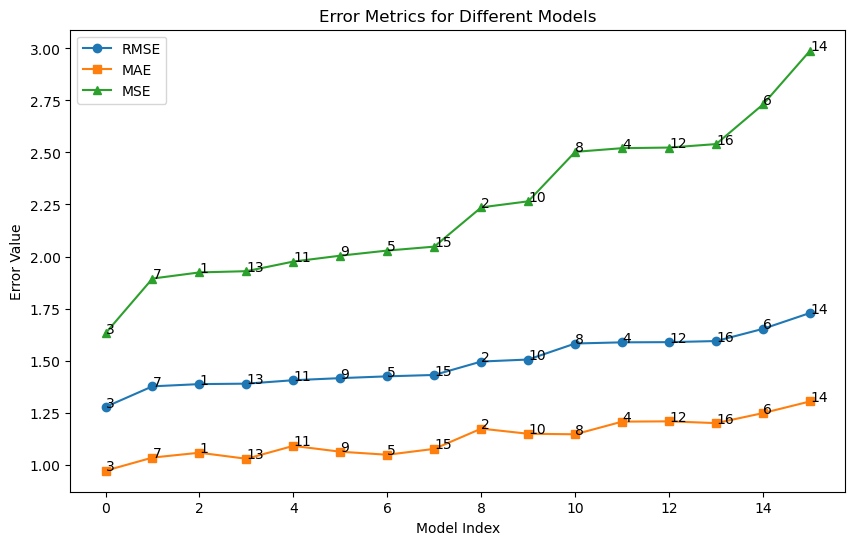

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

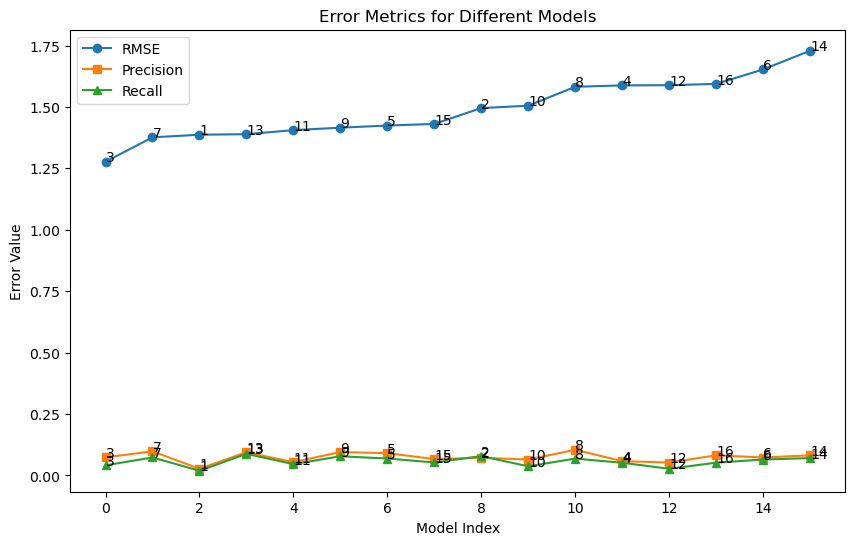

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

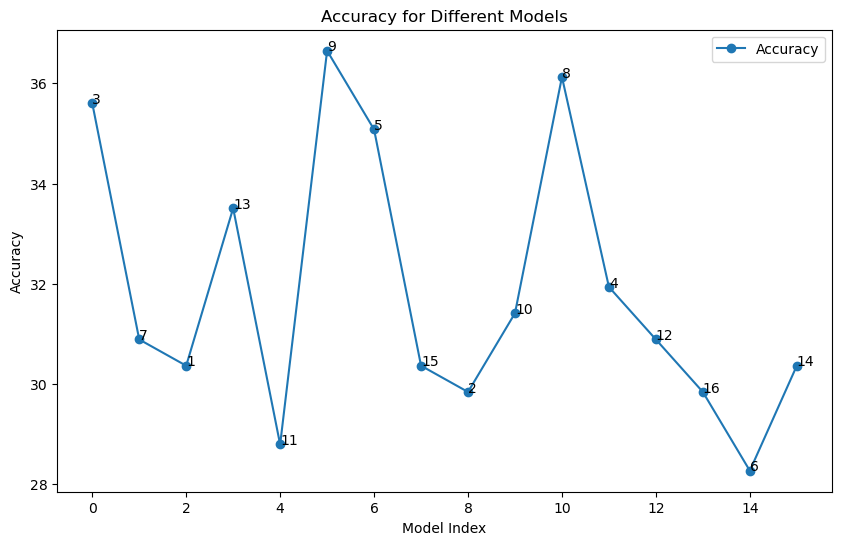

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = KnnWithMeans.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = knn_with_zscore.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Le Grand Saumur
2. Item ID: Beyerskloof Western Cape
3. Item ID: Mendoza Chardonnay
4. Item ID: Pinot blanc


In [25]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = KnnWithMeans.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = knn_with_zscore.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:
1. User ID: 918cd9b7-8057-4106-8f7f-9e9e3a423fb1
2. User ID: a0ef6b50-093e-4ae1-8e3c-58a2a17d2bb8


In [26]:
#get the KnnWithMeans for a user from the model
knn_with_zscore.get_neighbors_uid(user_id=5)

['4ed273f7-1816-4f36-88c7-789125f011c7',
 '838e0d9d-27e9-4f89-9eab-ba2c2f412759',
 '3b1f7bc8-6a23-47e5-97df-043bd1b97f12',
 '4ee63478-4f55-49ba-8e7f-87bd2c01d028',
 'ec237d07-aabf-47af-a3fa-2b60019d49d7',
 '5ccd8030-047b-432c-a630-d784ab415756',
 'f8c400a6-ded1-40b8-95d2-a263d05c30ce',
 'df904a46-c461-4233-9d44-6ac11a8bbddc',
 '83128cf9-f07f-4de1-97cf-cbde8d38bc3c',
 'eadb1fb9-7260-4618-aa5a-8f2ebdca2077']

In [27]:
#get the KnnWithMeans for an item from the model
knn_with_zscore.get_neighbors_iid(item_id=20)

['Morandina Valpolicella Ripasso Superiore',
 "Mercurey 'Clos les Bussières' ",
 'Iridium',
 'Pinot Bianco',
 'Franciacorta Milledì Brut',
 'Grauer Burgunder Muschelkalk',
 'Finca La sofia',
 "Moscata D'Asti Casaniere",
 'Brut Rosé (Rose Label) Champagne',
 'Dveri Pax Blaufränkisch']

In [28]:
knn_with_zscore.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn_with_zscore.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 16 with sim 0.000000000000000
user 18 with sim 0.000000000000000
And the baseline estimate is: 4.490037805666697

#####

Note: If the baseline is 2.942622950819672 then the value is a default value, Otherwise not


In [29]:
df_pred = knn_with_zscore.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Refosco,4.0,2.929508,"{'was_impossible': True, 'reason': 'User and/o...",39,1,1.070492
1,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Chance,3.0,3.000000,"{'actual_k': 21, 'was_impossible': False}",70,0,0.000000
2,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Il Mattaglio Blanc de Blancs,5.0,5.000000,"{'actual_k': 5, 'was_impossible': False}",70,1,0.000000
3,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Chablis Saint Martin,3.0,2.929508,"{'was_impossible': True, 'reason': 'User and/o...",70,0,0.070492
4,bc79b0e3-064d-4240-86de-e86499f577e8,3／17 Te Koko,5.0,2.929508,"{'was_impossible': True, 'reason': 'User and/o...",26,1,2.070492
5,5ccd8030-047b-432c-a630-d784ab415756,Haut-Medoc,3.0,2.929508,"{'was_impossible': True, 'reason': 'User and/o...",57,1,0.070492
6,b61f83a4-48c5-49a5-aee5-72f7d5221b2a,Prieuré Chambave Moscato Passito,1.0,2.000000,"{'actual_k': 0, 'was_impossible': False}",5,1,1.000000
7,918cd9b7-8057-4106-8f7f-9e9e3a423fb1,Chardonnay,5.0,3.800000,"{'actual_k': 0, 'was_impossible': False}",2,6,1.200000
8,5ccd8030-047b-432c-a630-d784ab415756,Grauburgunder Muschelkalk,4.0,2.929508,"{'was_impossible': True, 'reason': 'User and/o...",57,1,1.070492
9,23b6603a-928c-4e54-9c34-bdf3dcb45435,Gewurztraminer,5.0,1.000000,"{'actual_k': 0, 'was_impossible': False}",1,1,4.000000


* best predictions

In [30]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
140,c60f0ff1-ed30-4df6-a612-b9ae7ca0814b,Amarone,3.0,3.0,"{'actual_k': 0, 'was_impossible': False}",4,5,0.0
158,2ae69fac-d491-412f-8164-ccaf59a230c2,Morellino di Scansano 2021,1.0,1.0,"{'actual_k': 0, 'was_impossible': False}",6,5,0.0
21,f7fb310d-87f1-441a-94ab-f526f66b9ec1,Montefalco Rosso,1.0,1.0,"{'actual_k': 3, 'was_impossible': False}",5,5,0.0
49,1b4a91f7-a311-4db0-a5b1-867736c951fe,Morellino di Scansano 2021,1.0,1.0,"{'actual_k': 0, 'was_impossible': False}",2,5,0.0
27,f7fb310d-87f1-441a-94ab-f526f66b9ec1,Montefalco Rosso,1.0,1.0,"{'actual_k': 3, 'was_impossible': False}",5,5,0.0
138,e336887b-883b-4d9a-8cd3-060c25856bfb,Montepulciano 60,1.0,1.0,"{'actual_k': 0, 'was_impossible': False}",5,4,0.0
17,4ed273f7-1816-4f36-88c7-789125f011c7,Muscat de Beaumes-de-Venise,1.0,1.0,"{'actual_k': 1, 'was_impossible': False}",5,3,0.0
62,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Langhe Nebbiolo,3.0,3.0,"{'actual_k': 21, 'was_impossible': False}",70,2,0.0
164,4ed273f7-1816-4f36-88c7-789125f011c7,Pinot blanc,1.0,1.0,"{'actual_k': 0, 'was_impossible': False}",5,0,0.0
171,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Pinot Bianco,3.0,3.0,"{'actual_k': 1, 'was_impossible': False}",39,2,0.0


* worst predictions

In [31]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
52,4ed273f7-1816-4f36-88c7-789125f011c7,Moscato d'Asti,1.0,4.963578,"{'actual_k': 3, 'was_impossible': False}",5,3,3.963578
125,e336887b-883b-4d9a-8cd3-060c25856bfb,Casillero del diabolo merlot Chile,1.0,5.000000,"{'actual_k': 0, 'was_impossible': False}",5,1,4.000000
141,cabb87a0-6498-438a-beb7-676f72bddd09,Terroir de Granit Saint Joseph,1.0,5.000000,"{'actual_k': 0, 'was_impossible': False}",3,1,4.000000
9,23b6603a-928c-4e54-9c34-bdf3dcb45435,Gewurztraminer,5.0,1.000000,"{'actual_k': 0, 'was_impossible': False}",1,1,4.000000
121,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Reserva riesling estevez 2019,5.0,1.000000,"{'actual_k': 0, 'was_impossible': False}",19,2,4.000000
149,c145de85-6596-46ca-8005-de4b5c325710,3／4 大亂鬥 10,1.0,5.000000,"{'actual_k': 0, 'was_impossible': False}",5,1,4.000000
32,defee34b-7775-4889-b703-92b730d85e70,Zamò Bianco,5.0,1.000000,"{'actual_k': 0, 'was_impossible': False}",4,0,4.000000
57,c60f0ff1-ed30-4df6-a612-b9ae7ca0814b,Trento Doc,1.0,5.000000,"{'actual_k': 0, 'was_impossible': False}",4,0,4.000000
26,bf82194f-6108-4524-9cef-69c0231ac74b,Organic pinot grigio terre siciliane igt,1.0,5.000000,"{'actual_k': 0, 'was_impossible': False}",2,0,4.000000
81,c3371365-d499-4675-aa68-dbc7b11f0777,Picpoul de Pinet Higues de Beauvignac,5.0,1.000000,"{'actual_k': 0, 'was_impossible': False}",2,1,4.000000
